# Estimating COVID-19's $R_t$ for DFW Area

## Introduction

COVID-19 has been going on for a while and it seems like it is going to stay fruther than we would like. As days go by more and more people are getting affected by this novel coronavirus, and re-opening business becomes an as crucial concern as social distancing to slow down the spreading.

 We need some actionable insights on if our sitution is getting better or getting worse, helping us to make the deicision of whether:
 - it is more important to remain staying at home to slow down the spreading, 
 - or the spread is already slowed down  and it is more important to reopen the economy

Reporduction Number ($R_t$) can be the magical number advising us whether:
 - the spread is slowing down ($R_t$<=1) or
 - we should remain shelter-in-place since the virus is still spreading fast ($R_t$>1).

## Reproduction Number

Recently I read about [a really inspring article](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) from [Kevin Systrom](https://twitter.com/kevin) (and [replication in R](https://colab.research.google.com/drive/1iV1eRHaxirA--kmGIGbR1D67t8z8dUWN#scrollTo=wkFqlgDbgyZK) by [Ramnath Vaidyanathan](https://twitter.com/ramnath_vaidya)) using $R_t$ (Reproduction Number) as indicator of how fast the virus is spreading. 

In the article Kevin describes $R_t$ as:

> The number of people who become infected per infectious person at time 𝑡

We will use the same statistical method to estimate the $R_t$ on the county level, since people mostly travel within or between neighbor counties. I am going to run $R_t$ estimation on these counties: 
 - Dallas county
 - Collin county
 - Tarrant county
 - Denton county

Data is found online:

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv


## TL;DR

We use Bayesian estimation to estimate the most likely $R_t$ and found out it is likely the spread in North Texas has been relatively slowed down. 

Slow and steady, we will come through this together.


In [0]:
import pandas as pd
import numpy as np
from scipy import stats as sps
from scipy.interpolate import interp1d

In [0]:


url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url, index_col=False)

counties = ['Dallas, Texas, US', 'Collin, Texas, US', 'Denton, Texas, US', 'Tarrant, Texas, US']

df_dfw = df.loc[df.Combined_Key.isin(counties)]

In [0]:
# Drop all 0 axis, get day 0 for DFW
df_dfw = df_dfw.loc[:, (df_dfw != 0).any(axis=0)]
line_plot = df_dfw.T

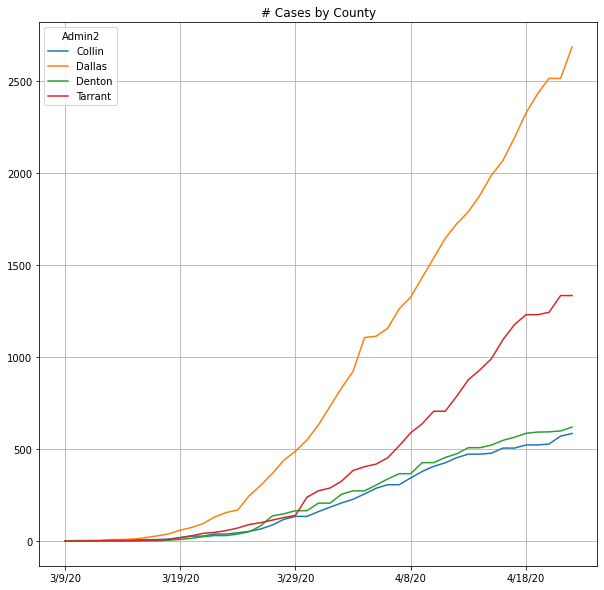

In [4]:

line_plot.columns = line_plot.loc['Admin2']
line_plot.iloc[11:,].plot.line(title='# Cases by County',figsize = (10,10), grid=True)

From March 9th, the number of cases in DFW area has been growing day by day. Dallas county has the most confirmed cases, reaching 2500+ cases since April 20th and the number is still rising. Tarrant county follows with 1300+ cases. Denton and Collin county looks realtively safer, both having around 600 cases each as of now.

Hypothetically the growth ought to be expoential, and with the great effort and sacrifice of social distancing and shelter-in-place, the growth is less like exponential and we are seeing the curve is getting flatten espeically for the Denton and Collin.

But is it enough? Is the growth really slowed down?

We are going to estimate R<sub>t</sub> for each of the four counties in DFW area.

In [0]:
new_cases =line_plot.iloc[11:,].diff()[1:]

new_cases_smooth = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

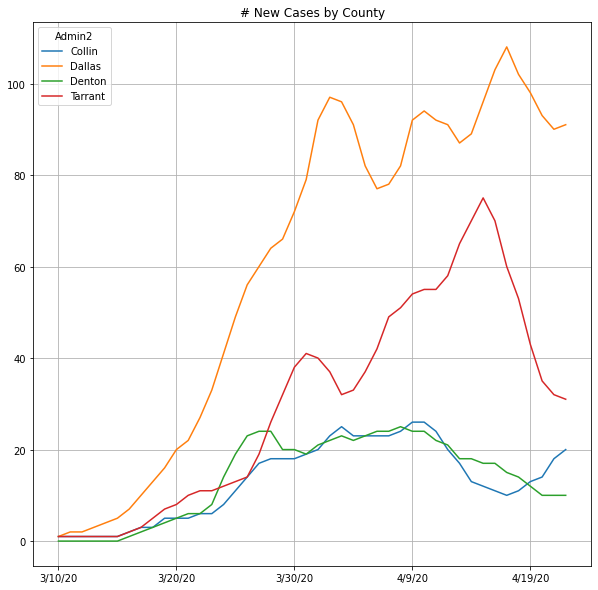

In [6]:
new_cases_smooth.plot.line(title='# New Cases by County',figsize = (10,10), grid=True)

We used the same smoothing method, and after the smoothing we can see the number of new cases oscilate. 

 - It looks like Tarrant county is having a lot less new cases now
 - Although Tarrant county confirmed 91 cases on 21st, after smoothing # of new cases actually slowed down to 35+ new cases
 - Dallas county new cases number is still on the rise
 - Collin and Denton are having relatively less # new cases

## Estimating $R_t$

We use the same method to get prosteriors probablities for R<sub>t</sub>.

In Kevin Systrom's article, he explained:

> The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$. The derivation is beyond the scope of this notebook, but here it is:


> $$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$
where $\gamma$ is the reciprocal of the serial interval (about 7 days for COVID19). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.


> $$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$








In [0]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example

rt_result = new_cases_smooth.copy()
hi_low = []
for col in new_cases_smooth:
    if col == 'Denton':
        posteriors, log_likelihood = get_posteriors(new_cases_smooth[col][6:], sigma=.25)
    else:
        posteriors, log_likelihood = get_posteriors(new_cases_smooth[col], sigma=.25)
    rt_result[col] = posteriors.idxmax()
    hi_low.append(highest_density_interval(posteriors))

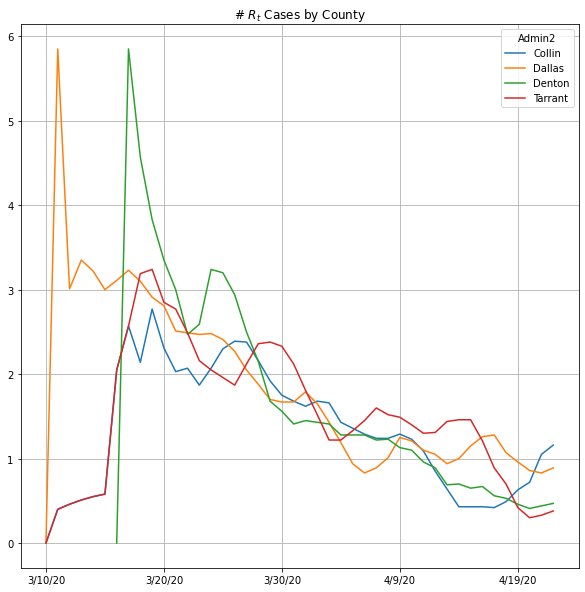

In [8]:
rt_result.plot.line(title='# $R_t$ Cases by County',figsize = (10,10), grid=True)

In [9]:
rt_result.tail()

Admin2,Collin,Dallas,Denton,Tarrant
4/18/20,0.49,1.07,0.53,0.70
4/19/20,0.63,0.96,0.46,0.42
4/20/20,0.72,0.86,0.41,0.30
4/21/20,1.05,0.83,0.44,0.33
4/22/20,1.16,0.89,0.47,0.38


From the result it seems like R<sub>t</sub> is contained well in North Texas. Although the number of confirmed cases is keep rising and it might be a scary scenario, but the spread of virus and growth of confirmed cases is actually slowed down.

If the virus was not contained, and hypehtically we have a R<sub>t</sub>> 1, we should have been seeing much more confirmed cases. 

The leveling even diminishing number of new cases during the last week gives us more confidence that this epidemic will be over and hopefully soon. We just need to hold on.

Stay safe my friends!

## P.S

The model I used in this analysis is outdated. [Kevin Systrom](https://twitter.com/kevin) has created a [much more sophiscated](https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb) model with a lot more cool techniques including:
 - predicting lag between confirmation date and onset date
 - adjust right-sensor data
 - sampling the posterior using Markov Chain Monte-Carlo

You can find out his latest work on http://rt.live/

Absolutely cool stuffs.

I really like this model seeing confirmation (or arrival) of new cases as a poisson process. Although the model I used in this analysis isn't as sophiscated as the newer one, it illustrates that the spread is actually slowing down and giving me more confidence.

Before this analysis, when I saw Dallas confirmed cases number just keep going up and up, I was actually pretty scared. After this analysis, I have much more confidence that we are on the right track.
